In [1]:
from torch.utils.data import Dataset
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import torch
import random
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
from random import randint
from augment_functions import random_mask, resize_encoder, augment_sample, augment_sample_random_mask
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
random.seed(42)
g = torch.Generator()
g.manual_seed(42)

In [3]:
def random_mask(sample, mask_prob=0.7):
    random_tensor = torch.rand(sample.shape, device=sample.device)
    mask = (random_tensor > mask_prob).float()
    masked_image = sample * mask
    return masked_image

class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob=0.7):
        self.data = data
        self.mask_prob = mask_prob
        
    def __len__(self):
        return (self.data.shape[0])

    def __getitem__(self, idx):
        x_orig = self.data[idx]
        x = resize_encoder(x_orig)
        masked_x = random_mask(x, mask_prob=self.mask_prob)
        masked_x_0_5 = random_mask(x, mask_prob=0.5)
        masked_x_0_3 = random_mask(x, mask_prob=0.3)
        y = idx
        return x_orig, x, masked_x, masked_x_0_3, masked_x_0_5, y

In [4]:
model = torch.load('simclr_decoder.pth', weights_only=False, map_location=DEVICE)
model.eval()

model = model.model.encoder

BATCH_SIZE = 20
data = torch.load('/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt')
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train:n_train+n_valid]
test_data = data[n_train+n_valid:]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

train_data = (train_data - mean) / std
test_dataset = WeatherBenchDataset(data=train_data, mask_prob=0.7)
trainloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)


In [5]:
def negative_cosine_sim_matrix(embeddings):
    z = F.normalize(embeddings, dim=1)
    sim_matrix = torch.matmul(z, z.T)
    N = sim_matrix.shape[0]
    mask = ~torch.eye(N, dtype=torch.bool, device=sim_matrix.device)
    negative_sims = sim_matrix[mask]
    return negative_sims


In [6]:
cos_sim_mean = []
rand_cos_sim_mean = []
mean_var = []
with torch.no_grad():
    for batch in testloader:
        X = batch[1].to(DEVICE)
        X_prime = batch[2].to(DEVICE)
        embeddings_x = model(X)[0]
        embeddings_x_prime = model(X_prime)[0]

        embeddings_x = embeddings_x.cpu()
        embeddings_x_prime = embeddings_x_prime.cpu()

        cos_sim = F.cosine_similarity(embeddings_x, embeddings_x_prime, dim=1)
        cos_sim_mean.append(cos_sim.mean().item())


        neg_cosine = negative_cosine_sim_matrix(embeddings_x)
        rand_cos_sim_mean.append(neg_cosine.mean().item())

        variance = embeddings_x.var(dim=0)
        mean_var.append(variance.mean().item())

cos_sim, rand_cos_sim, mean_var = np.mean(cos_sim_mean), np.mean(rand_cos_sim_mean), np.mean(mean_var)

print("Mean Cosine similarity:", cos_sim)
print("Negative Mean Cosine similarity:", rand_cos_sim)
print("Mean Variance of Embeddings", mean_var)


Mean Cosine similarity: 0.9097327093283335
Negative Mean Cosine similarity: 0.6394226614736084
Mean Variance of Embeddings 0.009320032930113057


In [7]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
masked_x_0_3 = batch[3].to(DEVICE)
masked_x_0_5 = batch[4].to(DEVICE)
y = batch[5].to(DEVICE)

print(x.shape)

torch.Size([20, 5, 144, 72])


In [8]:
with torch.no_grad():
    embeddings_x = model(x)[0]
    embeddings_masked_x = model(masked_x)[0]
    embeddings_masked_x_0_3 = model(masked_x_0_3)[0]
    embeddings_masked_x_0_5 = model(masked_x_0_5)[0]

Text(0.5, 1.0, 'Singular Value Spectrum')

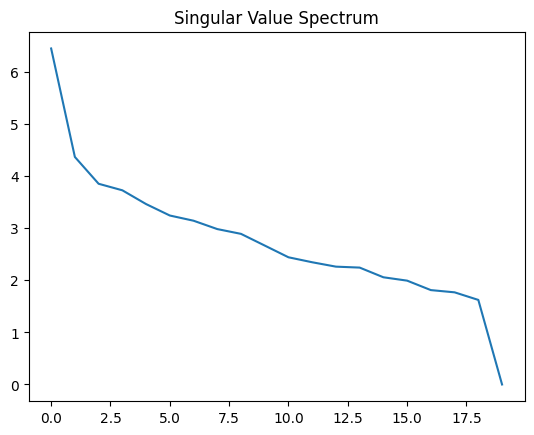

In [9]:
import torch
U, S, V = torch.svd(embeddings_x - embeddings_x.mean(0))
plt.plot(S.cpu().numpy()); plt.title("Singular Value Spectrum")


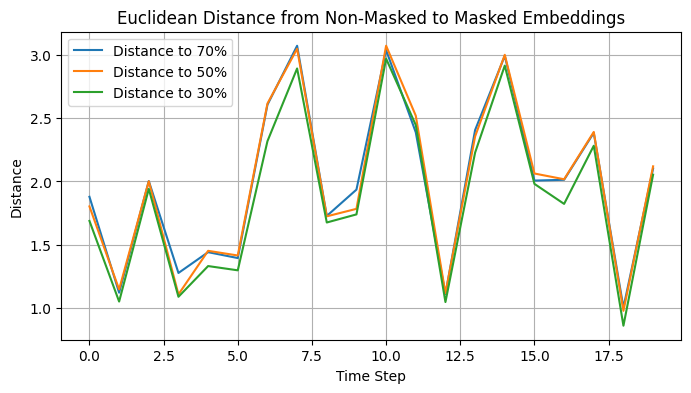

In [10]:
embeddings_x = embeddings_x.cpu()
embeddings_masked_x = embeddings_masked_x.cpu()
embeddings_masked_x_0_5 = embeddings_masked_x_0_5.cpu()
embeddings_masked_x_0_3 = embeddings_masked_x_0_3.cpu()
dist = np.linalg.norm(embeddings_x - embeddings_masked_x, axis=1)
dist2 = np.linalg.norm(embeddings_x - embeddings_masked_x_0_5, axis=1)
dist1 = np.linalg.norm(embeddings_x - embeddings_masked_x_0_3, axis=1)
plt.figure(figsize=(8, 4))
plt.plot(dist, label='Distance to 70%')
plt.plot(dist2, label='Distance to 50%')
plt.plot(dist1, label='Distance to 30%')
plt.title(f'Euclidean Distance from Non-Masked to Masked Embeddings')
plt.xlabel('Time Step')
plt.ylabel('Distance')
plt.legend()
plt.grid(True)
plt.show()

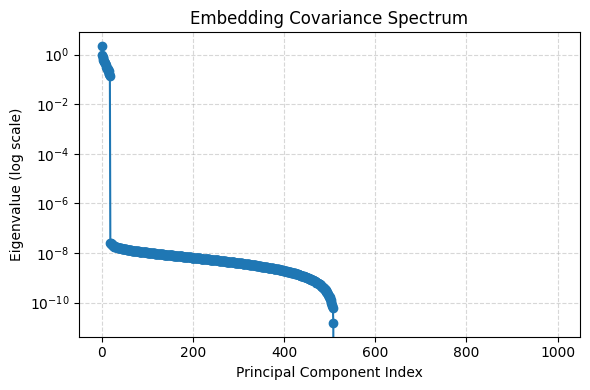

In [11]:

# 1) Suppose Z is your held-out embeddings, shape (N_samples, D_dims)
#    e.g. you’ve concatenated batches: Z = np.vstack(z_batch_list)
Z = embeddings_x  # load or assemble your array here

# 2) Center embeddings
Z_centered = Z - Z.mean(axis=0, keepdims=True)

# 3) Covariance matrix (D×D)
#    If N >> D, this is fine. If D >> N, you might prefer the N×N trick.
cov = (Z_centered.T @ Z_centered) / (Z_centered.shape[0] - 1)

# 4) Eigenvalues (use eigh since cov is symmetric)
eigvals = np.linalg.eigh(cov)[0]  # returns sorted in ascending order
eigvals = np.flip(eigvals)        # descending

# 5) Plot spectrum
plt.figure(figsize=(6,4))
plt.plot(eigvals, marker='o', linestyle='-')
plt.yscale('log')   # often useful to see tail behavior
plt.xlabel('Principal Component Index')
plt.ylabel('Eigenvalue (log scale)')
plt.title('Embedding Covariance Spectrum')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


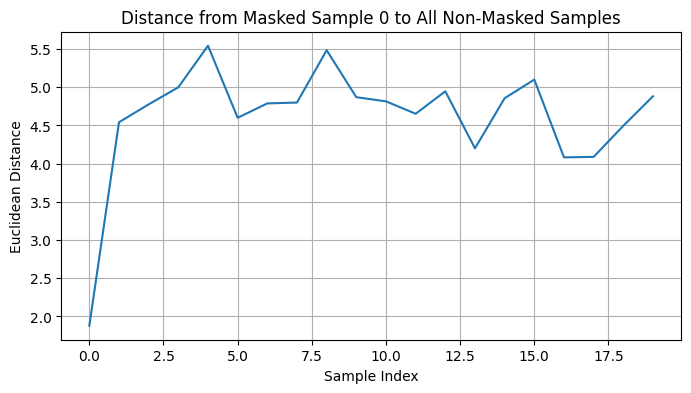

In [12]:
ref_embedding = embeddings_masked_x[0]  # shape: (embedding_dim,)
dist_to_all = np.linalg.norm(embeddings_x - ref_embedding, axis=1)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(dist_to_all)
plt.title('Distance from Masked Sample 0 to All Non-Masked Samples')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean Distance')
plt.grid(True)
plt.show()

In [13]:
embeddings_x = embeddings_x.cpu().numpy()
embeddings_masked_x = embeddings_masked_x.cpu().numpy()
embeddings_masked_x_0_3 = embeddings_masked_x_0_3.cpu().numpy()
embeddings_masked_x_0_5 = embeddings_masked_x_0_5.cpu().numpy()
y = y.cpu().numpy()

combined = np.vstack([embeddings_x, embeddings_masked_x, embeddings_masked_x_0_3, embeddings_masked_x_0_5])
pca = PCA(n_components = 2)
combined_proj = pca.fit_transform(combined)

x_proj = combined_proj[:len(embeddings_x)]
x_prime_proj = combined_proj[len(embeddings_x):len(embeddings_x)*2]
x_prime_proj_0_3 = combined_proj[len(embeddings_x)*2:len(embeddings_x)*3]
x_prime_proj_0_5 = combined_proj[len(embeddings_x)*3:len(embeddings_x)*4]


In [14]:
df = pd.DataFrame({
    'x': np.concatenate([x_proj[:, 0], x_prime_proj_0_3[:, 0], x_prime_proj_0_5[:, 0], x_prime_proj[:, 0]]),
    'y': np.concatenate([x_proj[:, 1], x_prime_proj_0_3[:, 1], x_prime_proj_0_5[:, 1], x_prime_proj[:, 1]]),
    'group': ['No Mask'] * BATCH_SIZE + ['30% Mask'] * BATCH_SIZE + ['50% Mask'] * BATCH_SIZE + ['70% Mask'] * BATCH_SIZE,
    'point_id': list(range(BATCH_SIZE)) * 4,
    'labels': list(y) *4
})

/tmp/ipykernel_3144681/4244481902.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


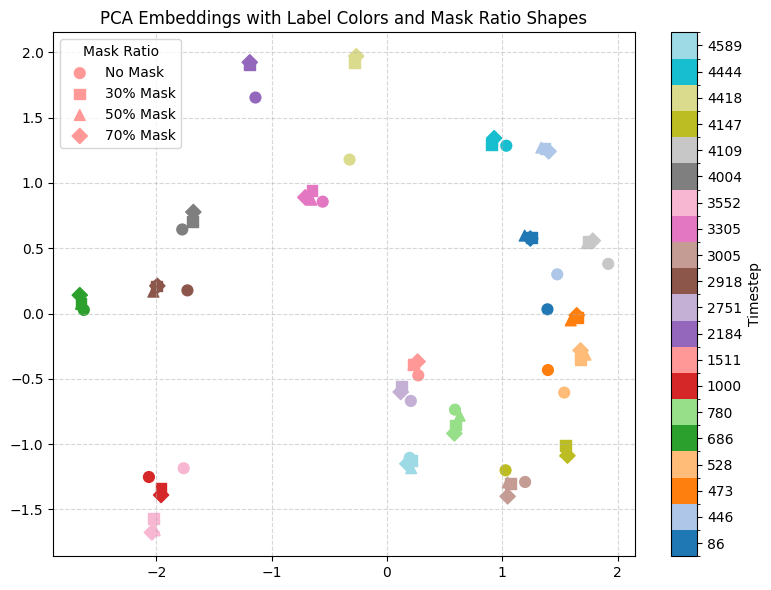

In [15]:
unique_labels = sorted(df['labels'].unique())
label_to_int = {label: i for i, label in enumerate(unique_labels)}
df['label_int'] = df['labels'].map(label_to_int)

cmap = plt.cm.get_cmap('tab20', len(unique_labels))
norm = mcolors.BoundaryNorm(np.arange(-0.5, len(unique_labels)+0.5), len(unique_labels))


markers = {'No Mask': 'o', '30% Mask': 's', '50% Mask': '^', '70% Mask': 'D'}

plt.figure(figsize=(8, 6))

for group, marker in markers.items():
    group_data = df[df['group'] == group]
    plt.scatter(
        group_data['x'],
        group_data['y'],
        c=group_data['label_int'],
        cmap=cmap,
        norm=norm,
        marker=marker,
        s=60,
        label=f'{group}'
    )

cbar = plt.colorbar(ticks=np.arange(len(unique_labels)))
cbar.set_label("Timestep")
cbar.ax.set_yticklabels(unique_labels)

plt.title("PCA Embeddings with Label Colors and Mask Ratio Shapes")
plt.legend(title='Mask Ratio')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [16]:
BATCH_SIZE = 256
data = torch.load('/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt')
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train:n_train+n_valid]
test_data = data[n_train+n_valid:]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

train_data = (train_data - mean) / std
test_dataset = WeatherBenchDataset(data=train_data, mask_prob=0.7)
trainloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [17]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
masked_x_0_3 = batch[3].to(DEVICE)
masked_x_0_5 = batch[4].to(DEVICE)
y = batch[5].to(DEVICE)

print(x.shape)

torch.Size([256, 5, 144, 72])


In [18]:
with torch.no_grad():
    embeddings_masked_x, _ = model(masked_x)
embeddings_masked_x =embeddings_masked_x.cpu()

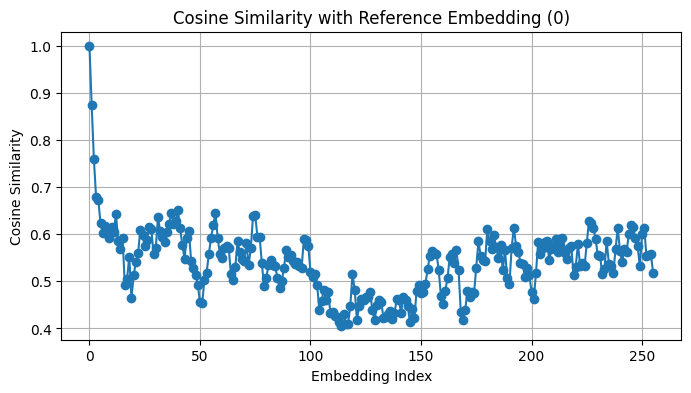

In [19]:
# Normalize the embeddings to unit vectors
embeddings_normalized = F.normalize(embeddings_masked_x, p=2, dim=1)

# Get the reference embedding (first one)
reference = embeddings_normalized[0]  # Shape: (embedding_dim,)

# Compute cosine similarity
cosine_similarities = torch.matmul(embeddings_normalized, reference)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(cosine_similarities.cpu().numpy(), marker='o')
plt.title('Cosine Similarity with Reference Embedding (0)')
plt.xlabel('Embedding Index')
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.show()

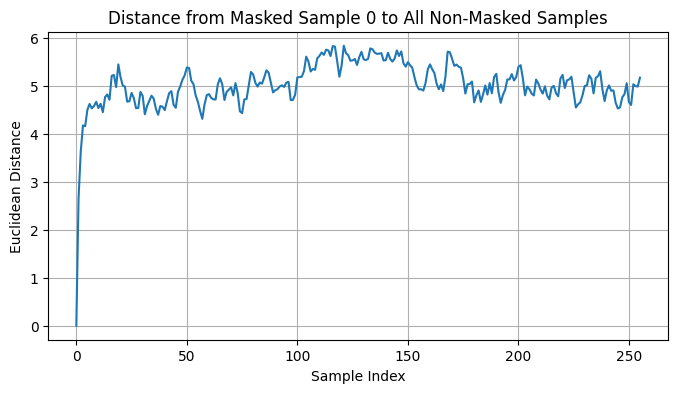

In [20]:
ref_embedding = embeddings_masked_x[0]  # shape: (embedding_dim,)
dist_to_all = np.linalg.norm(embeddings_masked_x - ref_embedding, axis=1)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(dist_to_all)
plt.title('Distance from Masked Sample 0 to All Non-Masked Samples')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean Distance')
plt.grid(True)
plt.show()

In [21]:
embeddings_masked_x = embeddings_masked_x.cpu().numpy()
y = y.cpu().numpy()

pca = PCA(n_components = 2)
x_proj = pca.fit_transform(embeddings_masked_x)


In [22]:
df = pd.DataFrame({
    'x': x_proj[:, 0],
    'y': x_proj[:, 1],
    'labels': y
})

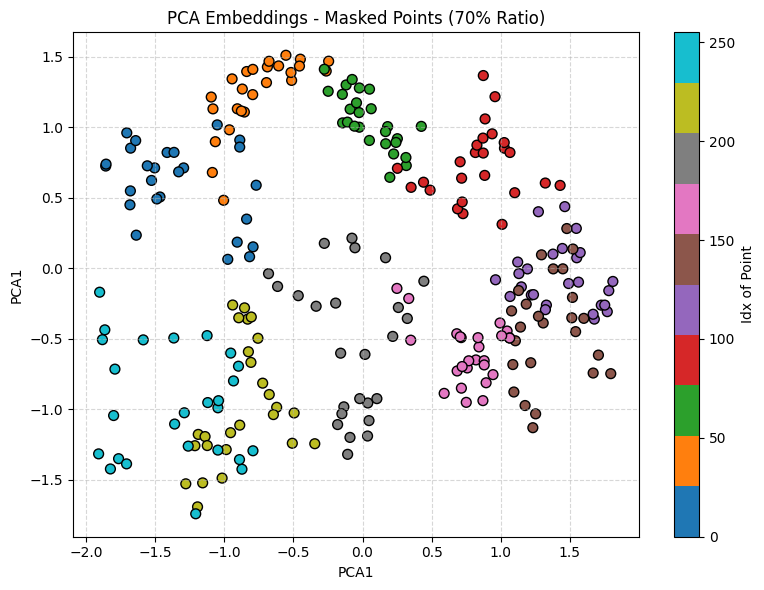

In [23]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['x'], df['y'], c=df['labels'], cmap='tab10', s=50, edgecolors='k')
plt.xlabel('PCA1')
plt.ylabel('PCA1')
plt.title('PCA Embeddings - Masked Points (70% Ratio)')
plt.colorbar(scatter, label='Idx of Point')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

import numpy as np

range_k = [4, 8, 12, 16, 24, 32]
nmi_scores = []
for k in range_k:
    temp_labels = np.arange(BATCH_SIZE) // (BATCH_SIZE // k)
    clust_labels = KMeans(n_clusters=k).fit_predict(embeddings_masked_x)
    nmi_scores.append(normalized_mutual_info_score(temp_labels, clust_labels))

print(nmi_scores)

[np.float64(0.6433468875443399), np.float64(0.6229740986414827), np.float64(0.6505275857456161), np.float64(0.7189041465101582), np.float64(0.744329623648697), np.float64(0.7724464205735744)]


In [25]:
step_dists = [np.linalg.norm(embeddings_masked_x[i+1] - embeddings_masked_x[i]) for i in range(len(embeddings_masked_x)-1)]
print(f"Mean Step Distances: {np.mean(step_dists):.4f}")

Mean Step Distances: 2.8174


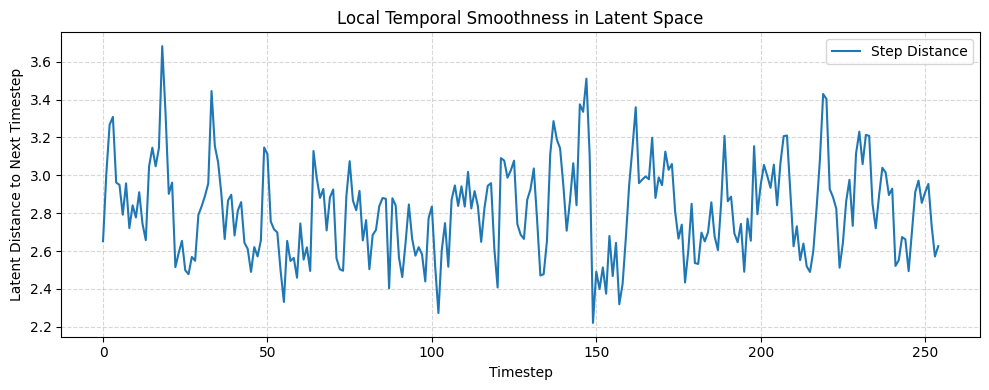

In [26]:

plt.figure(figsize=(10, 4))
plt.plot(step_dists, label='Step Distance')
plt.xlabel('Timestep')
plt.ylabel('Latent Distance to Next Timestep')
plt.title('Local Temporal Smoothness in Latent Space')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



T = len(embeddings_masked_x)
t = np.arange(T).reshape(-1,1)
X = embeddings_masked_x


t_train, t_test, X_train, X_test = train_test_split(
    t, X, test_size=0.2, random_state=0
)

d = 3
poly = PolynomialFeatures(degree=d, include_bias=True)
t_train_poly = poly.fit_transform(t_train)
t_test_poly  = poly.transform(t_test)

print(X.shape)
lr_model = LinearRegression()
lr_model.fit(t_train_poly, X_train)


X_pred = lr_model.predict(t_test_poly)

mse = mean_squared_error(X_test, X_pred)


print(f"MSE: {mse:.4f}")


(256, 1000)
MSE: 0.0102


In [28]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score



T = len(embeddings_masked_x)
t = np.arange(T).reshape(-1,1)
X = embeddings_masked_x


t_train, t_test, X_train, X_test = train_test_split(
    t, X, test_size=0.2, random_state=0
)


print(X.shape)
kr_model = KernelRidge(kernel="rbf", alpha=1.0, gamma=0.1)
kr_model.fit(t_train, X_train)


X_pred = kr_model.predict(t_test)

mse = mean_squared_error(X_test, X_pred)


print(f"MSE: {mse:.4f}")


(256, 1000)


MSE: 0.0076


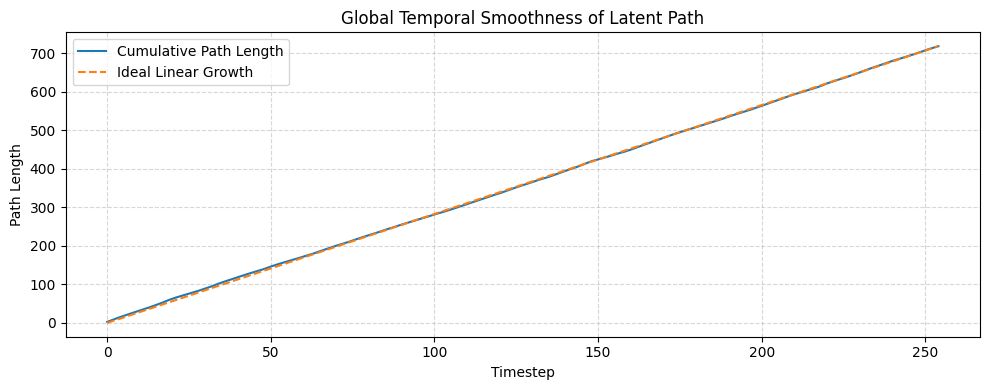

In [29]:
cumulative = np.cumsum(step_dists)
plt.figure(figsize=(10, 4))
plt.plot(cumulative, label='Cumulative Path Length')
plt.plot(np.linspace(0, cumulative[-1], len(cumulative)), '--', label='Ideal Linear Growth')
plt.xlabel('Timestep')
plt.ylabel('Path Length')
plt.title('Global Temporal Smoothness of Latent Path')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [30]:
step_series = pd.Series(step_dists)
autocorr = step_series.autocorr(lag=1)
print(f"Autocorrelation of step distances (lag=1): {autocorr:.3f}")


Autocorrelation of step distances (lag=1): 0.604


In [31]:
# z, _ = model(masked_x)
# mode_labels = ["2m_temperature", "u_component_of_wind", "v_component_of_wind", "geopotential", "specific_humidity"]
# for idx, mode in enumerate(mode_labels):
#     masked_x_hidden = torch.zeros_like(x)
#     masked_x_hidden[:, idx, :, :] = masked_x[:, idx, :, :]
#     hidden_z, _ = model(masked_x_hidden)
#     delta = F.mse_loss(z, hidden_z)
#     print(f"Keeping only mode: {mode} | Δ MSE from full input: {delta.item():.10f}")

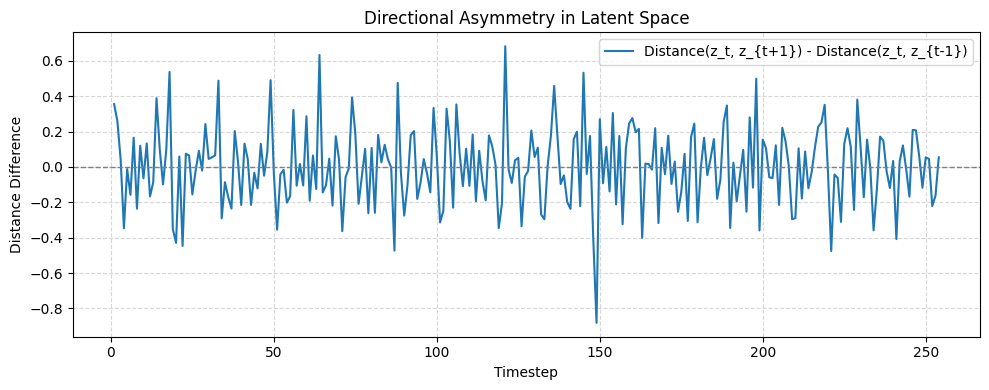

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# embeddings_masked_x: list or array of latent vectors (shape: [T, D])
embeddings = embeddings_masked_x

# Skip the first and last time steps to avoid index errors
dist_diffs = []
for t in range(1, len(embeddings) - 1):
    dist_forward = np.linalg.norm(embeddings[t] - embeddings[t + 1])
    dist_backward = np.linalg.norm(embeddings[t] - embeddings[t - 1])
    diff = dist_forward - dist_backward  # Positive = closer to z_{t-1}, negative = closer to z_{t+1}
    dist_diffs.append(diff)

# Plot the difference
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(embeddings) - 1), dist_diffs, label='Distance(z_t, z_{t+1}) - Distance(z_t, z_{t-1})')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Timestep')
plt.ylabel('Distance Difference')
plt.title('Directional Asymmetry in Latent Space')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Cumulative explained variance')

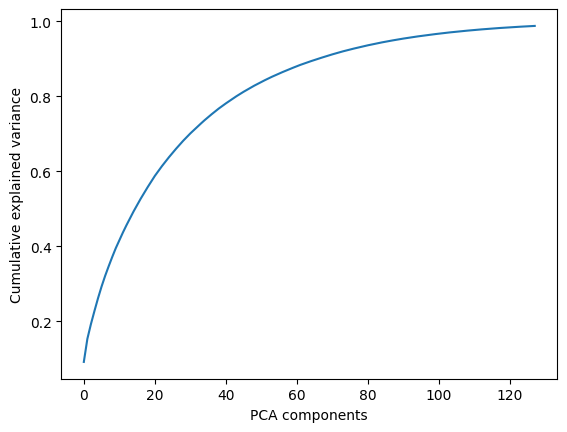

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=128)
pca.fit(embeddings)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PCA components')
plt.ylabel('Cumulative explained variance')


In [34]:
import numpy as np

def participation_ratio(eigenvalues):
    numerator = np.sum(eigenvalues) ** 2
    denominator = np.sum(eigenvalues ** 2)
    return numerator / denominator

eigenvalues = pca.explained_variance_
pr = participation_ratio(eigenvalues)
print(f"Participation Ratio (Effective Dimensions): {pr:.2f}")


Participation Ratio (Effective Dimensions): 37.72


In [35]:
# Train a neural ODE
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from neural_ode.neural_ode_model import NeuralODE, LatentTestDataset, train_neural_ode
# Encode the data
encoded_data_list = []
with torch.no_grad():
    for batch in testloader:
        encoded_data, _ = model(masked_x)
        encoded_data_list.append(encoded_data)

encoded_data_list = torch.cat(encoded_data_list, dim=0)

encoded_dataset = LatentTestDataset(data=encoded_data_list, context_length=BATCH_SIZE)
encoded_dataloder = DataLoader(encoded_dataset, batch_size=256, shuffle=False)

neural_model = NeuralODE(dim=encoded_data_list.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(neural_model.parameters(), lr=1e-2)
loss_fn = torch.nn.MSELoss()

neural_model = train_neural_ode(3, model=neural_model, trainloader=encoded_dataloder, optimizer=optimizer, loss_fn=loss_fn, device=DEVICE)


Epoch: 1, Train Loss: 0.0232
Epoch: 2, Train Loss: 0.0206
Epoch: 3, Train Loss: 0.0193


In [36]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
masked_x_0_3 = batch[3].to(DEVICE)
masked_x_0_5 = batch[4].to(DEVICE)
y = batch[5].to(DEVICE)

print(x.shape)

torch.Size([256, 5, 144, 72])


In [37]:
with torch.no_grad():
    embeddings_masked_x, _ = model(masked_x)
# embeddings_masked_x =embeddings_masked_x.cpu()

In [38]:
odefunc = neural_model.odefunc
odefunc.eval()
speeds = []

z_seq = embeddings_masked_x
t_seq = torch.linspace(0, 1, steps=z_seq.shape[0]).to(z_seq.device)

with torch.no_grad():
    for t_i, z_i in zip(t_seq, z_seq):
        v_i = odefunc(t_i, z_i.unsqueeze(0))
        speed = v_i.norm(dim=1).item()
        speeds.append(speed)

speeds = np.array(speeds)  
print(f"Speed Mean: {speeds.mean()}")
print(f"Speed Variance: {speeds.var()}")

Speed Mean: 13.973226686939597
Speed Variance: 18.12798303447172


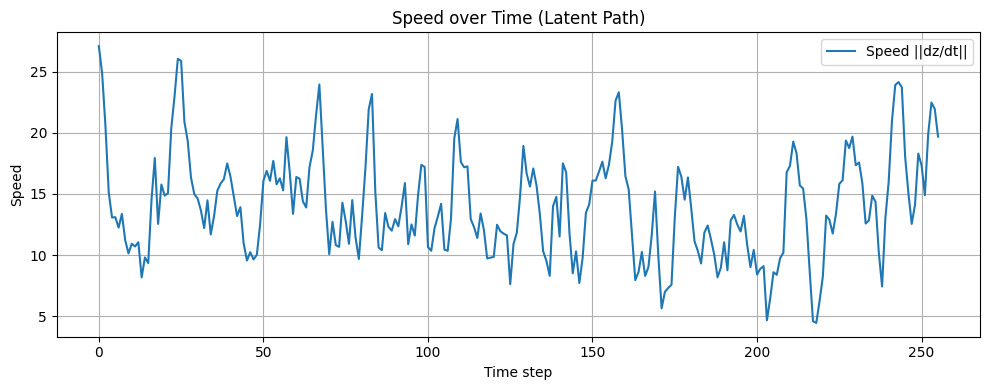

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(BATCH_SIZE), speeds, label='Speed ||dz/dt||')
plt.xlabel("Time step")
plt.ylabel("Speed")
plt.title("Speed over Time (Latent Path)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
curvatures = []

for i in range(len(t_seq)):
    d2f_dt2 = torch.zeros(z_seq.shape[1])
    t = t_seq[i].clone().detach().requires_grad_(True)
    z = z_seq[i].clone().detach().requires_grad_(True)
    f = odefunc(t, z.unsqueeze(0))[0]
    d2f_dt2 = torch.stack([
        torch.autograd.grad(f[j], t, create_graph=True)[0]
        for j in range(f.shape[0])
    ])
    curvatures.append(d2f_dt2.norm().item())
curvatures = np.array(curvatures)

In [41]:
print(f"Mean curvatures: {curvatures.mean()}")
print(f"Variance of curvatures: {curvatures.var()}")

Mean curvatures: 0.6750370968366042
Variance of curvatures: 0.026144380206097686


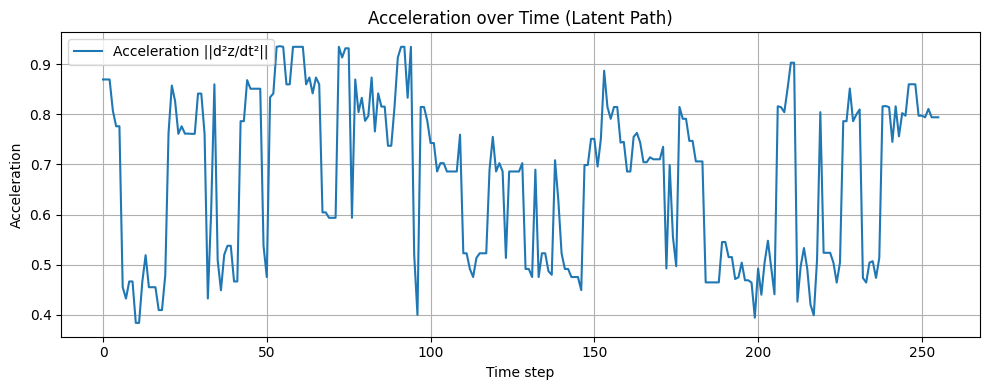

: 

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(BATCH_SIZE), curvatures, label='Acceleration ||d²z/dt²||')
plt.xlabel("Time step")
plt.ylabel("Acceleration")
plt.title("Acceleration over Time (Latent Path)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()